In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import cmocean
import datetime
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

In [2]:
# import own modules
import function_file as fp
from function_file import *
#fp.numeric_cols
#fp.pop_parameters
#fp.pop_parameters_dict
#fp.plot_hist_mult
#fp.plot_box_mult

In [3]:
# Retrieve path and load the data
path = os.getcwd()
df = pd.read_csv(path+"/train.csv")
dt = pd.read_csv(path+"/test.csv")

# Number of rows and columns
print('df train', df.shape)
print('df test', dt.shape)

df.head(3)

df train (6895, 70)
df test (767, 69)


,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,65,66,65,14,11,12,12,12,NaN,LB
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,65,61,58,10,13,7,6,11,NaN,LDM
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,60,58,59,10,10,8,10,11,NaN,LWB


#### player identification and overall qualification variables  
- id: Unique identifier for each player.
- short_name: Short name or nickname of the player.
- birthday_date: Player's date of birth.
- height_cm: Player's height in centimeters.
- weight_kg: Player's weight in kilograms.  --> [Good for identifying Strikers & Central backs]

- overall: Player's overall rating, representing their overall skill level.
- potential: Player's potential rating, indicating their potential skill growth.
- international_reputation: Player's international reputation level.
- club_name: Name of the player's club.
- league_name: Name of the league the club belongs to.
  
#### player financial metrics  
- value_eur: Player's market value in euros.
- wage_eur: Player's weekly wage in euros.
  
#### player position related metrics  
- position: Player's preferred playing position.[TARGET VARIABLE]
- preferred_foot: Player's preferred kicking foot (left or right).
- weak_foot: Player's weak foot rating, indicating their weaker kicking foot's ability.
- skill_moves: Player's skill moves rating, representing their dribbling and ball control skills.

#### high level attributes  
- pace 
- shooting 
- passing 
- dribbling 
- defending 
- physic: Attributes representing different aspects of a player's playing style and skills.

#### mentality attributes  
- mentality_aggression
- mentality_vision
- mentality_composure: Attributes representing mental aspects of a player's game.

#### attacking attributes  
- attacking_crossing
- attacking_finishing 
- attacking_heading_accuracy: Attributes related to attacking and finishing skills.

#### movement attributes 
- movement_acceleration
- movement_sprint_speed
- movement_agility: Attributes related to a player's speed and agility.  

#### strength attributes 
- power_shot_power
- power_jumping
- power_stamina: Attributes representing a player's physical power and endurance.  

#### defending attributes
- defending_marking_awareness
- defending_standing_tackle
- defending_sliding_tackle: Attributes representing a player's defensive skills.


#### Goalkeeper attributes  

- goalkeeping_diving
- goalkeeping_handling
- goalkeeping_positioning: Goalkeeping attributes related to diving, handling, and positioning.
- goalkeeping_reflexes
- goalkeeping_speed: Attributes representing a goalkeeper's reflexes and speed.

# Feature Transformations

In [4]:
# Calculate age of players
df['birthday_date'] = pd.to_datetime(df['birthday_date'], format='%Y-%m-%d', errors='coerce')
df['today'] = pd.to_datetime('2022-11-01',format='%Y-%m-%d', errors='coerce')


df['age'] = ((df['today'] - df['birthday_date'])/np.timedelta64(1, 'Y'))
df['age'] = df['age'].astype(int)

In [5]:
df.position.unique()

array(['LB', 'LDM', 'LWB', 'LS', 'RW', 'GK', 'LCM', 'RM', 'RCM', 'LW',
       'LCB', 'RB', 'RCB', 'CDM', 'RDM', 'CAM', 'CB', 'ST', 'RS', 'LM',
       'RWB', 'LF', 'RF', 'CM'], dtype=object)

In [6]:
# Creating high level position
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB']),
     df['position'].isin(['LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM']),
     df['position'].isin(['LW','LF','CF','RF','RW']),
     df['position'].isin(['LS','ST','RS'])
     
]

choices = ['GK', 'CB', 'CDM', 'CM','CAM','CF','ST']

df['base_position'] = np.select(conditions, choices, default='other')

In [7]:
# Creating high position location
conditions = [
    df['position'].isin(['GK','CB','CDM','CM','CAM','CF','ST']),
     df['position'].isin(['RCB','RDM','RCM','RAM','RF','RS']),
     df['position'].isin(['LCB','LDM','LCM','LAM','LF','LS']),
     df['position'].isin(['RB','RWB','RM','RW']),
     df['position'].isin(['LB','LWB','LM','LW'])
     
]

choices = ['CC', 'CR', 'CL', 'R','L']

df['position_loc'] = np.select(conditions, choices, default='other')

In [8]:
# Creating high position location
conditions = [
    df['position'].isin(['LB','LWB','LM','LW','RB','RWB','RM','RW'])
     
]

choices = ['yes']

df['is_wing'] = np.select(conditions, choices, default='no')

In [9]:
# Creating high level position
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB']),
     df['position'].isin(['LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM']),
     df['position'].isin(['LW','LF','CF','RF','RW']),
     df['position'].isin(['LS','ST','RS'])
     
]

choices = [0, 1, 2, 3,4,5,6]

df['position_ord'] = np.select(conditions, choices, default=-1)

In [10]:
df

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,today,age,base_position,position_loc,is_wing,position_ord
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,12,12,NaN,LB,2022-11-01,32,CB,L,yes,1
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,6,11,NaN,LDM,2022-11-01,26,CDM,CL,no,2
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,10,11,NaN,LWB,2022-11-01,21,CDM,L,yes,2
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,8,9,NaN,LS,2022-11-01,30,ST,CL,no,6
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,12,15,NaN,LB,2022-11-01,32,CB,L,yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,1997-12-10,180,65,Carlisle United,...,8,13,NaN,RCB,2022-11-01,24,CB,CR,no,1
6891,187961,Paulinho,83,83,28500000.0,61000,1988-07-25,183,80,Al Ahli,...,6,8,NaN,LCM,2022-11-01,34,CM,CL,no,3
6892,257234,Y. Hamache,70,80,3400000.0,6000,1999-07-13,177,73,Boavista FC,...,8,10,NaN,LWB,2022-11-01,23,CDM,L,yes,2
6893,232511,S. Sasaki,71,71,1300000.0,7000,1989-10-02,176,70,Sanfrecce Hiroshima,...,10,8,NaN,LCB,2022-11-01,33,CB,CL,no,1


# Exploratory Data Analysis

In [11]:
# Players main attributes
player_char = df[['id','short_name','age','height_cm','weight_kg','overall','potential',
                  'international_reputation','club_name','league_name','position','base_position','position_loc','is_wing','position_ord']]

In [12]:
# Players main attributes - numeric vars
player_num_vars = fp.numeric_cols(player_char)

In [13]:
pop_parameters(player_char[player_num_vars])

,size,datatype,unique_values,mean,stdv,min,per25,median,per75,max,IQRs,lower_bound,upper_bound
id,6895,int64,6895,223463.55,26875.00,41,207602.5,227951.0,242423.5,264481,34821.0,155371.0,294655.0
age,6895,int64,27,28.10,4.33,18,25.0,28.0,31.0,44,6.0,16.0,40.0
height_cm,6895,int64,46,181.48,6.86,156,177.0,182.0,186.0,203,9.0,163.5,199.5
weight_kg,6895,int64,47,75.53,7.04,53,70.0,75.0,80.0,103,10.0,55.0,95.0
overall,6895,int64,45,68.83,5.95,49,65.0,68.0,72.0,93,7.0,54.5,82.5
potential,6895,int64,42,72.03,6.07,53,68.0,72.0,76.0,95,8.0,56.0,88.0
international_reputation,6895,int64,5,1.15,0.48,1,1.0,1.0,1.0,5,0.0,1.0,1.0
position_ord,6895,int64,7,2.45,1.83,0,1.0,2.0,3.0,6,2.0,-2.0,6.0


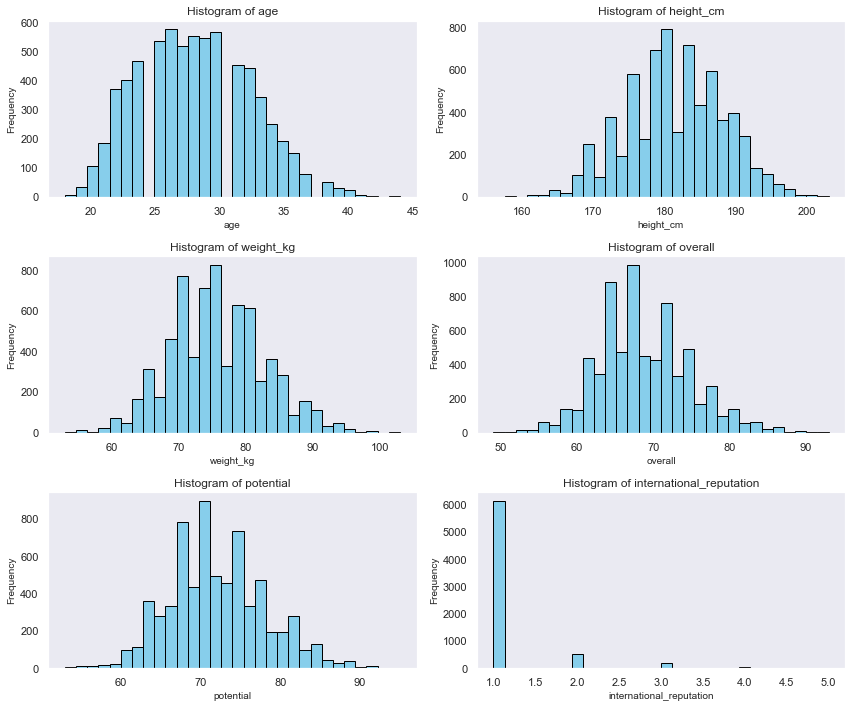

In [14]:
# Plot distributions
fp.plot_hist_mult(player_char[player_num_vars].iloc[:,1:7],3,2,30)

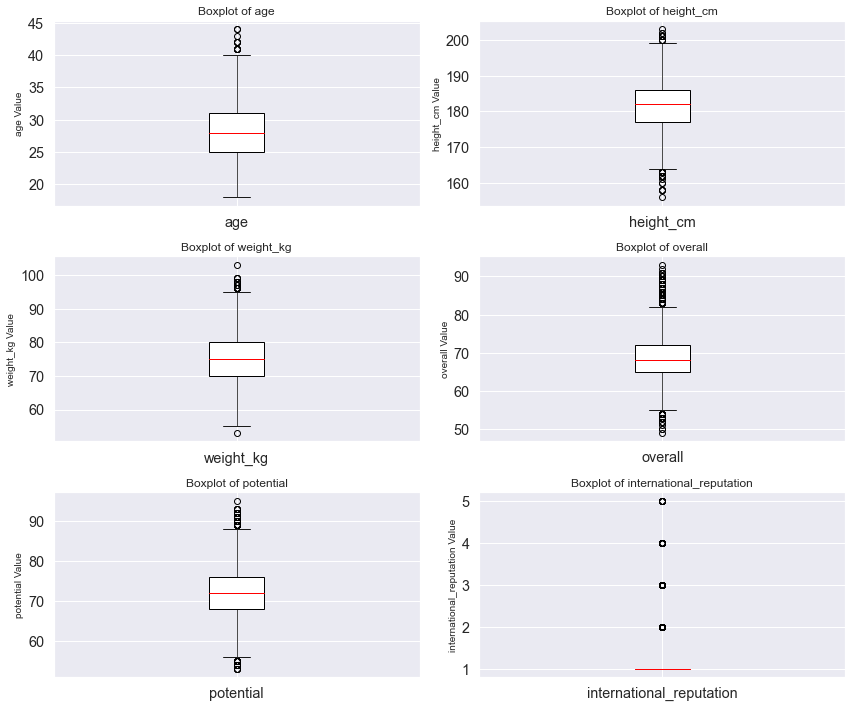

In [15]:
fp.plot_box_mult(player_char[player_num_vars].iloc[:,1:7],3,2)

## Studying Players based on their base position

In [16]:
id_player = player_char.groupby(['base_position'])[player_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [17]:
id_player

,base_position,id,age,height_cm,weight_kg,overall,potential,international_reputation,position_ord
0,GK,213369.209,29.800,188.989,82.740,69.545,72.425,1.192,0.0
1,CB,224212.377,28.218,183.161,77.022,68.302,71.439,1.116,1.0
2,CDM,224616.058,27.832,180.009,73.518,68.611,72.034,1.129,2.0
3,CM,226389.115,27.520,177.743,72.069,68.728,72.113,1.131,3.0
4,CAM,221775.677,27.597,177.399,71.989,70.616,73.897,1.259,4.0
5,CF,227761.174,26.992,177.152,71.192,69.366,73.124,1.220,5.0
6,ST,220593.117,28.578,183.169,77.753,69.330,72.136,1.199,6.0


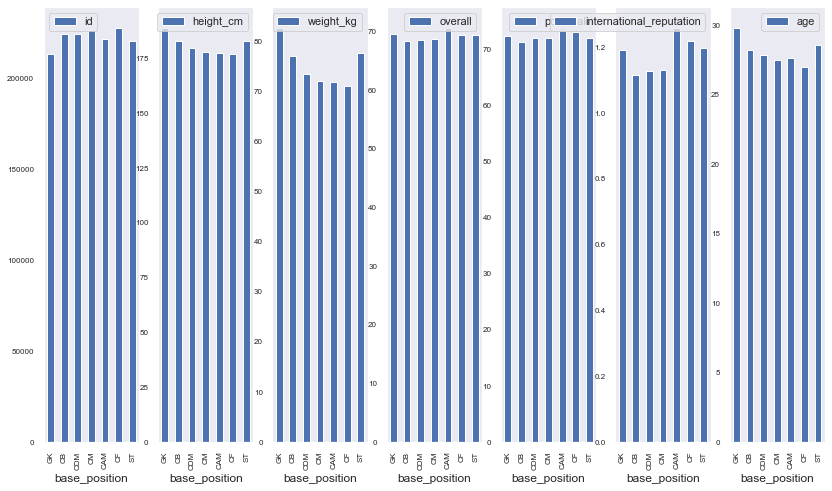

In [18]:
fp.groupby_table(id_player,'base_position')

- Defenders tend to be heavier than midfielders and strikers.
- Interesting difference in international reputation between defensive and atacking positions.
- The more attacking oriented the position, players tend to be younger
  
  
 ##### follow up variables: weight, international reputation and age

## Studying Players based on their position location

In [19]:
id_player_loc = player_char.groupby(['base_position','position_loc'])[player_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [20]:
id_player_loc.head()

,base_position,position_loc,id,age,height_cm,weight_kg,overall,potential,international_reputation,position_ord
0,GK,CC,213369.209,29.800,188.989,82.740,69.545,72.425,1.192,0.0
1,CB,CC,215393.485,29.359,186.491,80.000,67.617,70.060,1.108,1.0
2,CB,CL,222494.938,28.510,186.471,80.036,68.368,71.612,1.136,1.0
3,CB,CR,223259.398,28.276,186.363,79.843,68.368,71.517,1.116,1.0
4,CB,L,226582.348,27.968,178.009,72.222,68.285,71.419,1.099,1.0


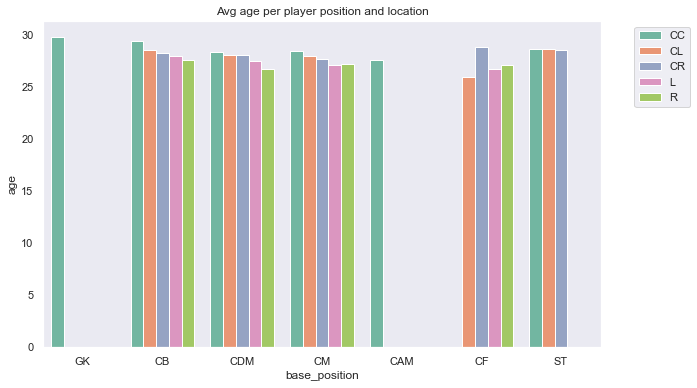

In [21]:
plt.figure(figsize=(10, 6)) 
#cpal = sns.color_palette("cmo.deep", n_colors=5)
cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_loc, x="base_position", y="age", hue="position_loc", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

- Find attribute to differentiate CAM from other Midfielders

- Players playing in the wings are more likely to be a bit younger than those playing in centric positions

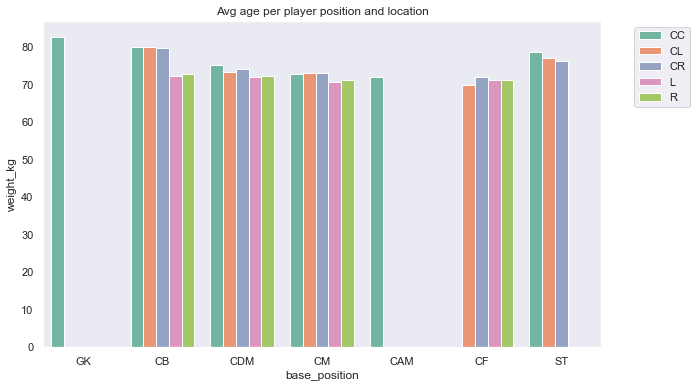

In [22]:
plt.figure(figsize=(10, 6)) 
#cpal = sns.color_palette("cmo.deep", n_colors=5)
cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_loc, x="base_position", y="weight_kg", hue="position_loc", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

- On the other hand, players with a larger weight tend to be positioned in central back positions or as Central Strikers.

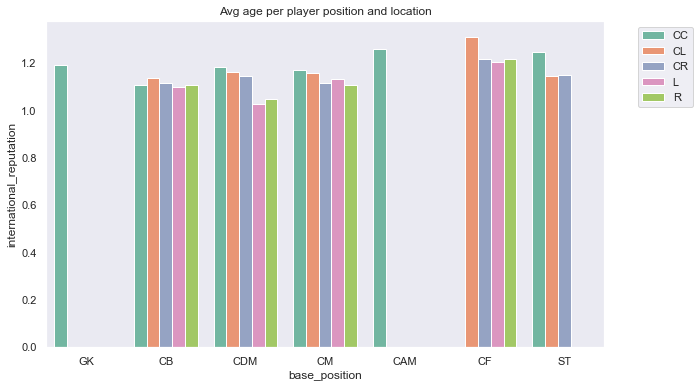

In [23]:
plt.figure(figsize=(10, 6)) 
#cpal = sns.color_palette("cmo.deep", n_colors=5)
cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_loc, x="base_position", y="international_reputation", hue="position_loc", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

- No major differences

In [24]:
id_player_wing = player_char.groupby(['base_position','is_wing'])[player_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [25]:
id_player_wing

,base_position,is_wing,id,age,height_cm,weight_kg,overall,potential,international_reputation,position_ord
0,GK,no,213369.209,29.800,188.989,82.740,69.545,72.425,1.192,0.0
1,CB,no,222002.588,28.506,186.425,79.947,68.280,71.388,1.124,1.0
2,CB,yes,227622.517,27.774,178.124,72.508,68.337,71.516,1.104,1.0
3,CDM,no,223189.197,28.112,180.465,74.083,69.445,72.676,1.163,2.0
4,CDM,yes,228409.587,27.087,178.798,72.014,66.394,70.327,1.038,2.0
5,CM,no,224347.949,27.849,178.694,72.979,68.669,72.026,1.140,3.0
6,CM,yes,228936.423,27.108,176.556,70.934,68.802,72.221,1.119,3.0
7,CAM,no,221775.677,27.597,177.399,71.989,70.616,73.897,1.259,4.0
8,CF,no,227443.234,27.406,176.469,70.891,69.703,73.188,1.266,5.0
9,CF,yes,227822.464,26.913,177.283,71.250,69.301,73.111,1.211,5.0


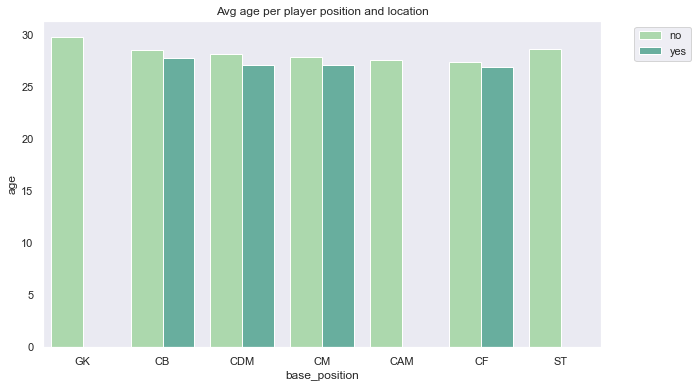

In [26]:
plt.figure(figsize=(10, 6)) 
cpal = sns.color_palette("cmo.deep", n_colors=5)
#cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_wing, x="base_position", y="age", hue="is_wing", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

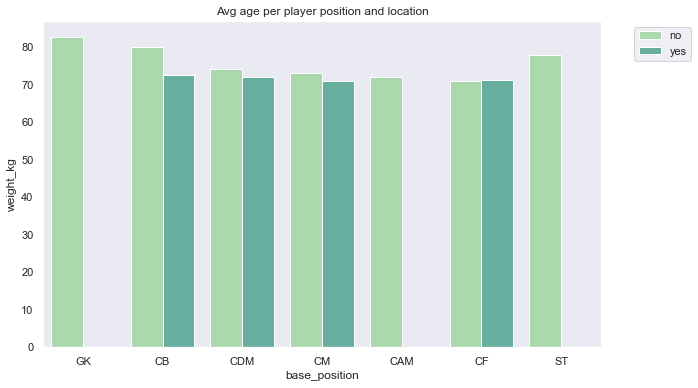

In [27]:
plt.figure(figsize=(10, 6)) 
cpal = sns.color_palette("cmo.deep", n_colors=5)
#cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_wing, x="base_position", y="weight_kg", hue="is_wing", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

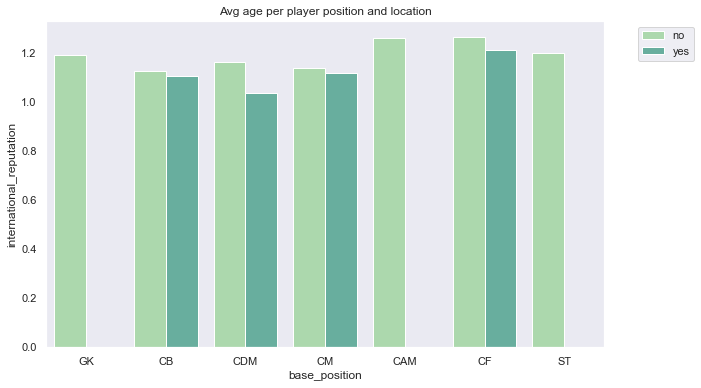

In [28]:
plt.figure(figsize=(10, 6)) 
cpal = sns.color_palette("cmo.deep", n_colors=5)
#cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_wing, x="base_position", y="international_reputation", hue="is_wing", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

## Studying Financial metrics

In [29]:
# Player financial attributes
player_finance = df[['id','position','value_eur','wage_eur',
                     'base_position','position_loc','is_wing','position_ord']]

finance_num_vars = fp.numeric_cols(player_finance)

In [30]:
pop_parameters(player_finance[finance_num_vars])

,size,datatype,unique_values,mean,stdv,min,per25,median,per75,max,IQRs,lower_bound,upper_bound
id,6895,int64,6895,223463.55,26875.00,41.0,207602.5,227951.0,242423.5,264481.0,34821.0,155371.0,294655.0
value_eur,6895,float64,240,4320388.07,10524781.02,25000.0,725000.0,1400000.0,2900000.0,194000000.0,2175000.0,-2537500.0,6162500.0
wage_eur,6895,int64,131,12034.13,24629.03,500.0,2000.0,4000.0,12000.0,350000.0,10000.0,-13000.0,27000.0
position_ord,6895,int64,7,2.45,1.83,0.0,1.0,2.0,3.0,6.0,2.0,-2.0,6.0


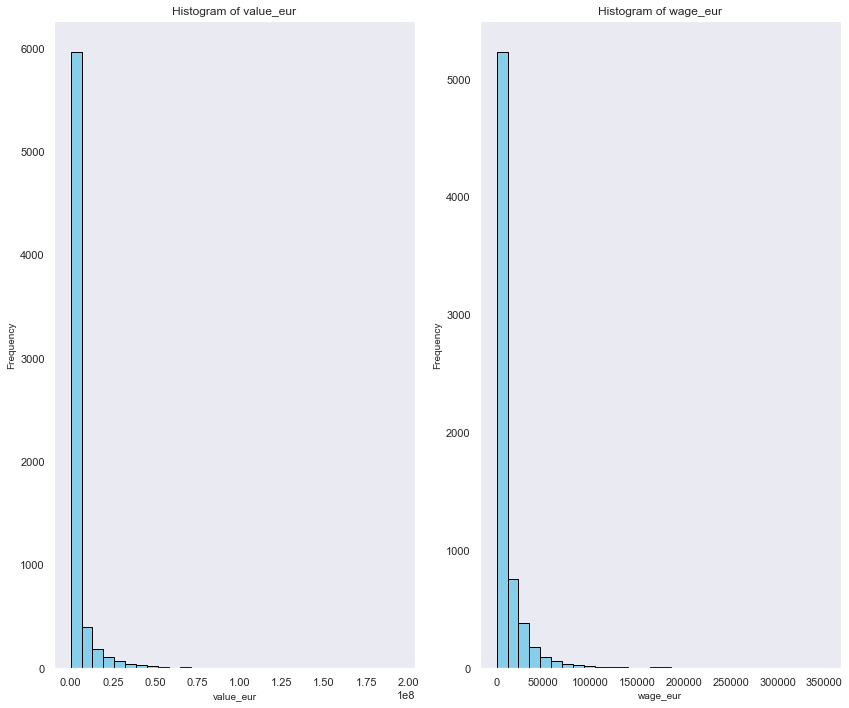

In [31]:
fp.plot_hist_mult(player_finance[finance_num_vars].iloc[:,1:3],1,2,30)

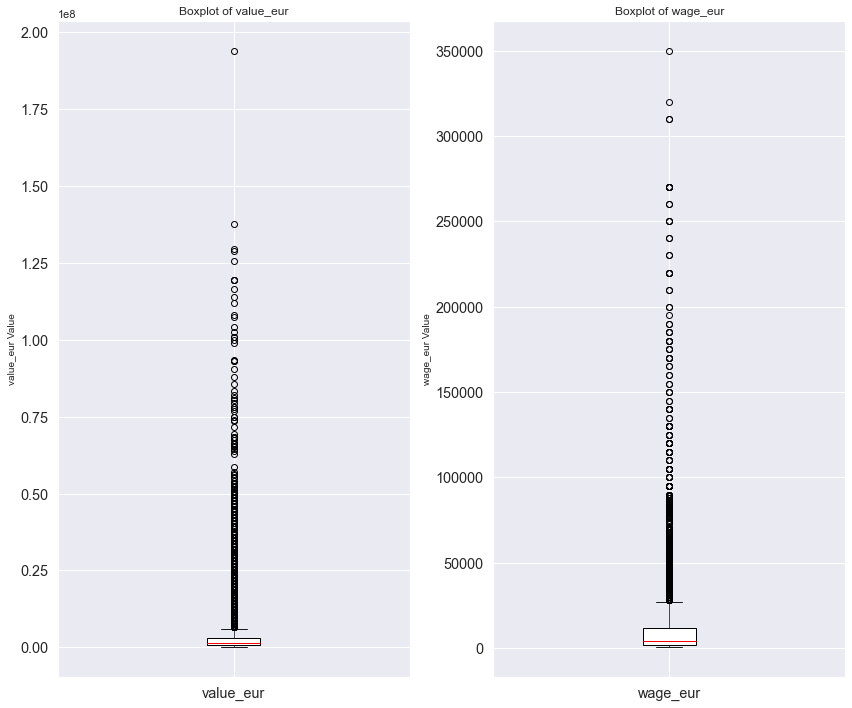

In [32]:
fp.plot_box_mult(player_finance[finance_num_vars].iloc[:,1:3],1,2)

In [33]:
id_finance_loc = player_finance.groupby(['base_position'])[finance_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [34]:
id_finance_loc.head()

,base_position,id,value_eur,wage_eur,position_ord
0,GK,213369.209,3827694.136,10505.943,0.0
1,CB,224212.377,3510898.471,10669.299,1.0
2,CDM,224616.058,4129296.978,12093.627,2.0
3,CM,226389.115,4405699.216,11629.898,3.0
4,CAM,221775.677,6477794.677,14906.654,4.0


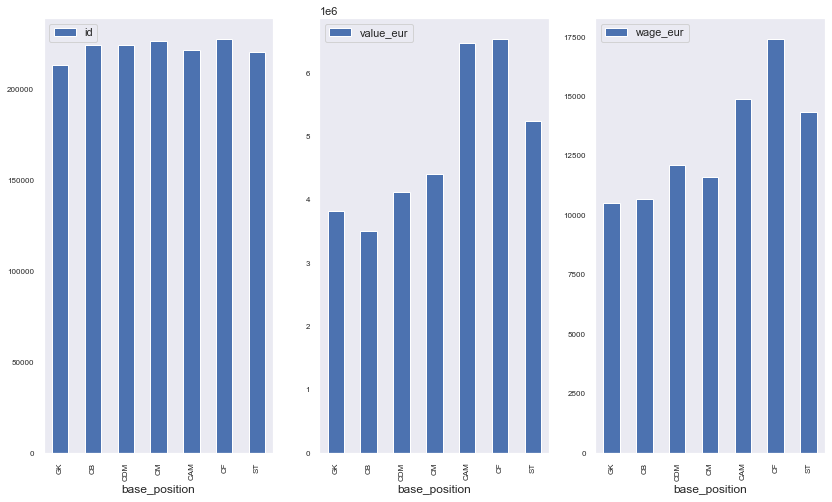

In [35]:
fp.groupby_table2(id_finance_loc,'base_position')